In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# Import Datasets
df_seq = pd.read_csv('/content/gdrive/My Drive/Bioinformatics/pdb_data_seq.csv')
df_char = pd.read_csv('/content/gdrive/My Drive/Bioinformatics/pdb_data_no_dups.csv')

In [4]:
# 2). ----- Filter and Process Dataset ------

# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

# Select only necessary variables to join
protein_char = protein_char[['structureId','classification']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [5]:
protein_char.head()

,structureId,classification
2,101M,OXYGEN TRANSPORT
4,102L,HYDROLASE(O-GLYCOSYL)
5,102M,OXYGEN TRANSPORT
7,103L,HYDROLASE(O-GLYCOSYL)
8,103M,OXYGEN TRANSPORT


In [6]:
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,sequence
structureId,,
101M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [7]:
# Check NA counts
model_f.isnull().sum()

classification      1
sequence          469
dtype: int64

In [8]:
# Drop rows with missing values
model_f = model_f.dropna()
print('%d is the number of proteins that have a classification and sequence' %model_f.shape[0])

345197 is the number of proteins that have a classification and sequence


HYDROLASE                           46193
TRANSFERASE                         36264
OXIDOREDUCTASE                      34223
IMMUNE SYSTEM                       15586
LYASE                               11644
                                    ...  
Fluorescent Protein, replication        1
ISOMERASE/ANTIBIOTIC                    1
ADHESION GLYCOPROTEIN                   1
METHYL-CPG-BINDING PROTEIN              1
CELL ADHESION, RIBOSOMAL PROTEIN        1
Name: classification, Length: 4458, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


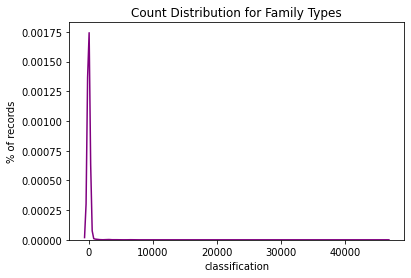

In [9]:
# Look at classification type counts
counts = model_f.classification.value_counts()
print(counts)

#plot counts
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

In [10]:
print(counts['HYDROLASE'])
print(counts['LIGASE'])
print(counts['TRANSFERASE'])
print(counts['OXIDOREDUCTASE'])
print(counts['ISOMERASE'])
print(counts['LYASE'])

46193
4926
36264
34223
6345
11644


In [11]:
max_length=model_f["sequence"].str.len().max()

In [12]:
# Get classification types where counts are over 1000
#types = np.asarray(counts[(counts > 1000)].index)
types=['HYDROLASE'
,'LIGASE'
,'TRANSFERASE'
,'OXIDOREDUCTASE'
,'ISOMERASE'
,'LYASE']

# Filter dataset's records for classification types > 1000
data = model_f[model_f.classification.isin(types)]

#data_m = data[(data['classification'] =='HYDROLASE' )  (data['classification'] =='LIGASE' ) or (data['classification'] =='TRANSFERASE' ) or (data['classification'] =='OXIDOREDUCTASE' ) or (data['classification'] =='ISOMERASE' ) or (data['classification'] =='LYASE' )]

print(types)
print('%d is the number of records in the final filtered dataset' %data.shape[0])

['HYDROLASE', 'LIGASE', 'TRANSFERASE', 'OXIDOREDUCTASE', 'ISOMERASE', 'LYASE']
139595 is the number of records in the final filtered dataset


In [13]:
train=data
a=train.classification.unique()
l=len(train.classification.unique())
print(a)

['HYDROLASE' 'LIGASE' 'TRANSFERASE' 'OXIDOREDUCTASE' 'ISOMERASE' 'LYASE']


In [14]:
for i in range (l):
    train.classification = train.classification.replace(a[i], i)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [15]:
train.classification.head()

structureId
117E    0
117E    0
11AS    1
11AS    1
11BA    0
Name: classification, dtype: int64

In [16]:
train.classification.value_counts()

0    46193
2    36264
3    34223
5    11644
4     6345
1     4926
Name: classification, dtype: int64

In [17]:
df = train
df.classification = df.classification.astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import SpatialDropout1D
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import GlobalMaxPool1D
from keras.utils import plot_model
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from sklearn.feature_selection import RFE
import re
import tensorflow as tf

In [19]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~।', lower=False)
tokenizer.fit_on_texts(df.sequence.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 34735 unique tokens.


In [20]:
X = tokenizer.texts_to_sequences(df.sequence.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (139595, 250)


In [21]:
Y = pd.get_dummies(df.classification).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (139595, 6)


In [22]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=.10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 32)           3232      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 125, 64)           24832     
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1024128   
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

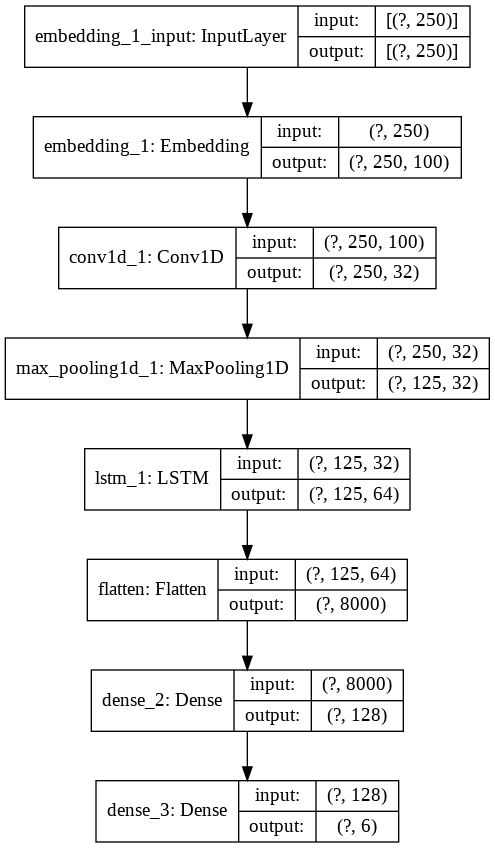

In [27]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(32, 1, activation= 'relu'))
model.add(MaxPooling1D(2))
model.add(LSTM(64, activation='relu',return_sequences=True))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(l, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

plot_model(model,'model.png',show_shapes=True)


In [29]:
epochs = 5
batch_size = 64

In [30]:
history = model.fit(train_features, train_labels, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
1767/1767 [==============================] - 332s 188ms/step - loss: 0.7224 - accuracy: 0.7080 - val_loss: 0.2867 - val_accuracy: 0.8889
Epoch 2/5
1767/1767 [==============================] - 335s 190ms/step - loss: 0.0954 - accuracy: 0.9660 - val_loss: 0.2692 - val_accuracy: 0.9144
Epoch 3/5
1767/1767 [==============================] - 339s 192ms/step - loss: 0.0399 - accuracy: 0.9864 - val_loss: 0.2177 - val_accuracy: 0.9186
Epoch 4/5
1767/1767 [==============================] - 334s 189ms/step - loss: 0.0241 - accuracy: 0.9927 - val_loss: 0.2011 - val_accuracy: 0.9263
Epoch 5/5
1767/1767 [==============================] - 333s 189ms/step - loss: 0.0168 - accuracy: 0.9947 - val_loss: 0.2303 - val_accuracy: 0.9192


In [31]:
accr = model.evaluate(test_features,test_labels)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

437/437 [==============================] - 10s 23ms/step - loss: 0.2421 - accuracy: 0.9150
Test set
  Loss: 0.242
  Accuracy: 0.915


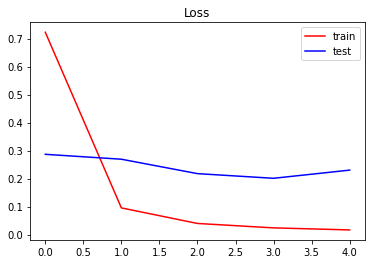

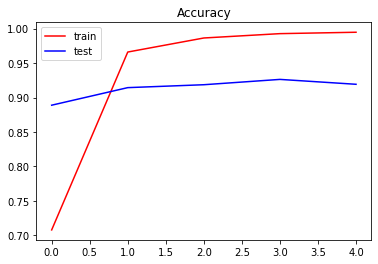

In [32]:
 from matplotlib import pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'],'r', label='train')
plt.plot(history.history['val_loss'],'b', label='test')
plt.legend()
plt.show()
plt.title('Accuracy')
plt.plot(history.history['accuracy'],'r', label='train')
plt.plot(history.history['val_accuracy'],'b', label='test')
plt.legend()
plt.show()

In [33]:
predicted_classes = model.predict(test_features)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


In [34]:
predicted_classes.shape, test_labels.shape
print(test_labels.shape)

(13960, 6)


In [35]:
test_Y = np.argmax(np.round(test_labels),axis=1)

In [36]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(6)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.88      0.95      0.91      4751
     Class 1       1.00      0.84      0.91       495
     Class 2       1.00      0.88      0.94      3610
     Class 3       0.87      0.94      0.90      3360
     Class 4       1.00      0.88      0.94       584
     Class 5       0.98      0.89      0.93      1160

    accuracy                           0.92     13960
   macro avg       0.95      0.90      0.92     13960
weighted avg       0.92      0.92      0.92     13960



In [37]:
name=[]
for i in range(6):
  name.append(i)


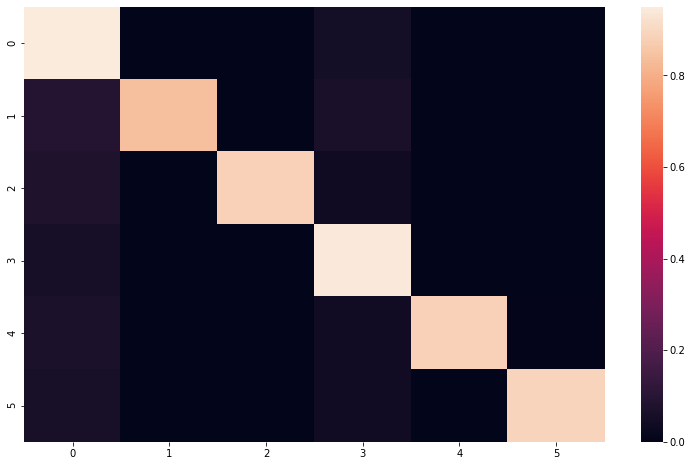

In [38]:
# Plot confusion matrix
conf_mat = confusion_matrix(test_Y, predicted_classes, labels = name)

#Normalize confusion_matrix
conf_mat = conf_mat.astype('float')/ conf_mat.sum(axis=1)[:, np.newaxis]

# Plot Heat Map
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.heatmap(conf_mat)

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[4509    0    4  230    0    8]
 [  45  416    0   32    1    1]
 [ 274    0 3194  134    0    8]
 [ 192    0    3 3164    0    1]
 [  41    0    0   24  516    3]
 [  70    1    4   49    1 1035]]
Normalized confusion matrix
[[9.49e-01 0.00e+00 8.42e-04 4.84e-02 0.00e+00 1.68e-03]
 [9.09e-02 8.40e-01 0.00e+00 6.46e-02 2.02e-03 2.02e-03]
 [7.59e-02 0.00e+00 8.85e-01 3.71e-02 0.00e+00 2.22e-03]
 [5.71e-02 0.00e+00 8.93e-04 9.42e-01 0.00e+00 2.98e-04]
 [7.02e-02 0.00e+00 0.00e+00 4.11e-02 8.84e-01 5.14e-03]
 [6.03e-02 8.62e-04 3.45e-03 4.22e-02 8.62e-04 8.92e-01]]


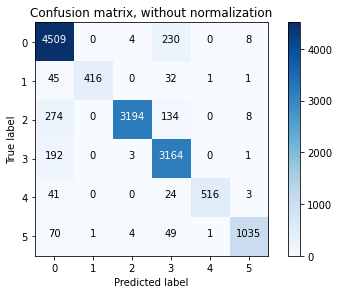

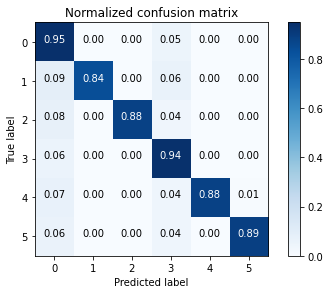

In [39]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


class_names = name

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_Y, predicted_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()